# Model Comparison: LR vs RF vs SVM

This notebook:
- Loads the reviews dataset
- Recreates a common train/test split
- Loads three trained Spark models:
  - Logistic Regression
  - Random Forest
  - SVM (LinearSVC via OneVsRest)
- Evaluates them on the same test set
- Plots bar charts to compare all three models

## 1. Setup & Imports

In [1]:
import os
from pathlib import Path
import warnings
import zipfile

import rootutils

# Optional: point Spark temp dir somewhere with enough space
os.environ["SPARK_LOCAL_DIRS"] = str(Path.home() / "spark-tmp")

# Detect project root (expects `.project-root` marker somewhere above)
rootutils.setup_root(Path.cwd(), indicator=".project-root", pythonpath=True)

ROOT_DIR = Path(os.environ.get("PROJECT_ROOT", Path.cwd()))
print(f"Project root: {ROOT_DIR}")

warnings.filterwarnings("ignore")

# For metrics aggregation and plotting
import pandas as pd
import matplotlib.pyplot as plt

Project root: /home/max/projects/nulp/amazon-reviews-analysis


## 2. Initialize Spark

In [2]:
from src.amazon_reviews_analysis.utils import build_spark

spark = build_spark()

print("✓ Spark Session created successfully!")
print(f"Spark Version: {spark.version}")
print(f"Spark App Name: {spark.sparkContext.appName}")
print(f"Spark Master: {spark.sparkContext.master}")
print(f"Spark UI: {spark.sparkContext.uiWebUrl}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/03 12:43:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✓ Spark Session created successfully!
Spark Version: 4.0.1
Spark App Name: AmazonReviews
Spark Master: local[*]
Spark UI: http://IdeaPad-Pro-5-14AHP9:4040


## 3. Load Data

⚠️ Adjust `DATA_ZIP` / `EXTRACT_DIR` if your paths differ.

We follow the RF/SVM layout. Change if needed.

In [3]:
DATA_ZIP = ROOT_DIR / "data/classification_reviews.zip"
EXTRACT_DIR = ROOT_DIR / "data/classification"

if not EXTRACT_DIR.exists():
    print(f"📦 Extracting {DATA_ZIP}...")
    with zipfile.ZipFile(DATA_ZIP, "r") as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)
    print("✓ Extraction complete!")
else:
    print("✓ Data already extracted")

print(f"\nData location: {EXTRACT_DIR}")

df = spark.read.parquet(str(EXTRACT_DIR))

print(f"Total records: {df.count():,}")
print(f"\nColumns: {df.columns}")
df.printSchema()

df.show(5, truncate=80)

✓ Data already extracted

Data location: /home/max/projects/nulp/amazon-reviews-analysis/data/classification
Total records: 35,202,489

Columns: ['rating', 'title', 'text', 'verified_purchase', 'parent_asin', 'category_label', 'label']
root
 |-- rating: double (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- category_label: string (nullable = true)
 |-- label: integer (nullable = true)

+------+-------------------------------+--------------------------------------------------------------------------------+-----------------+-----------+--------------+-----+
|rating|                          title|                                                                            text|verified_purchase|parent_asin|category_label|label|
+------+-------------------------------+--------------------------------------------------------------------------------+---

## 4. Prepare Common Train/Test Split

We:
- Cast `label` to double
- Use a single `randomSplit` (`[0.8, 0.2], seed=42`) for all models

In [4]:
from pyspark.sql.functions import col, count, when

TEXT_COL = "text"
TARGET_COL = "label"  # 0=negative, 1=neutral, 2=positive

# Label is already 0, 1, 2 - cast to double for ML
df_clean = df.withColumn("label", col(TARGET_COL).cast("double"))

print(f"Clean dataset: {df_clean.count():,} records")
print("\nLabel distribution (0=negative, 1=neutral, 2=positive):")
df_clean.groupBy("label").count().orderBy("label").show()

# Common split for evaluation
train_df, test_df = df_clean.randomSplit([0.8, 0.2], seed=42)

print(f"Training set: {train_df.count():,} records")
print(f"Test set: {test_df.count():,} records")

Clean dataset: 35,202,489 records

Label distribution (0=negative, 1=neutral, 2=positive):
+-----+--------+
|label|   count|
+-----+--------+
|  0.0| 5372399|
|  1.0| 2451737|
|  2.0|27378353|
+-----+--------+



Training set: 28,158,683 records


Test set: 7,043,806 records


## 5. Load Trained Models

Directories (from your training notebooks):
- Logistic Regression: `models/spark_lr_classifier`
- Random Forest: `models/spark_rf_classifier`
- SVM (LinearSVC + OneVsRest): `models/spark_svm_classifier`

In [5]:
from pyspark.ml import PipelineModel

MODEL_DIR_LR = ROOT_DIR / "models" / "spark_lr_classifier"
MODEL_DIR_RF = ROOT_DIR / "models" / "spark_rf_classifier"
MODEL_DIR_SVM = ROOT_DIR / "models" / "spark_svm_classifier"

print("Loading models...")
lr_model = PipelineModel.load(str(MODEL_DIR_LR))
rf_model = PipelineModel.load(str(MODEL_DIR_RF))
svm_model = PipelineModel.load(str(MODEL_DIR_SVM))

print("✓ All models loaded successfully!")
print(f"LR model path:  {MODEL_DIR_LR}")
print(f"RF model path:  {MODEL_DIR_RF}")
print(f"SVM model path: {MODEL_DIR_SVM}")

Loading models...
✓ All models loaded successfully!
LR model path:  /home/max/projects/nulp/amazon-reviews-analysis/models/spark_lr_classifier
RF model path:  /home/max/projects/nulp/amazon-reviews-analysis/models/spark_rf_classifier
SVM model path: /home/max/projects/nulp/amazon-reviews-analysis/models/spark_svm_classifier


## 6. Evaluate Models

We compute:
- Accuracy
- F1 Score
- Weighted Precision
- Weighted Recall

for each model on the same `test_df`.

In [6]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def evaluate_model(model, test_df, label_col="label", prediction_col="prediction", model_name="model"):
    """
    Run predictions and compute metrics for a given model.
    Returns a dict: { 'model': ..., 'accuracy': ..., 'f1': ..., 'precision': ..., 'recall': ... }
    """
    print(f"\n▶ Evaluating {model_name}...")
    preds = model.transform(test_df)
    
    evaluator = MulticlassClassificationEvaluator(
        labelCol=label_col,
        predictionCol=prediction_col,
    )
    
    accuracy  = evaluator.setMetricName("accuracy").evaluate(preds)
    f1        = evaluator.setMetricName("f1").evaluate(preds)
    precision = evaluator.setMetricName("weightedPrecision").evaluate(preds)
    recall    = evaluator.setMetricName("weightedRecall").evaluate(preds)
    
    print(f"{model_name} RESULTS")
    print(f"  Accuracy:           {accuracy:.4f}")
    print(f"  F1 Score:           {f1:.4f}")
    print(f"  Weighted Precision: {precision:.4f}")
    print(f"  Weighted Recall:    {recall:.4f}")
    
    return {
        "model": model_name,
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

results = []
results.append(evaluate_model(lr_model,  test_df, model_name="Logistic Regression"))
results.append(evaluate_model(rf_model,  test_df, model_name="Random Forest"))
results.append(evaluate_model(svm_model, test_df, model_name="SVM (LinearSVC + OvR)"))

metrics_df = pd.DataFrame(results)
metrics_df


▶ Evaluating Logistic Regression...


25/12/03 12:45:48 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Logistic Regression RESULTS
  Accuracy:           0.8461
  F1 Score:           0.8158
  Weighted Precision: 0.8119
  Weighted Recall:    0.8461

▶ Evaluating Random Forest...


Random Forest RESULTS
  Accuracy:           0.6991
  F1 Score:           0.7210
  Weighted Precision: 0.7492
  Weighted Recall:    0.6991

▶ Evaluating SVM (LinearSVC + OvR)...


SVM (LinearSVC + OvR) RESULTS
  Accuracy:           0.8299
  F1 Score:           0.7851
  Weighted Precision: 0.7905
  Weighted Recall:    0.8299


,model,accuracy,f1,precision,recall
0,Logistic Regression,0.846131,0.815755,0.811852,0.846131
1,Random Forest,0.699115,0.720966,0.749209,0.699115
2,SVM (LinearSVC + OvR),0.829897,0.785146,0.790527,0.829897


## 7. Bar Plots: Compare Models

We'll create:
- One grouped bar chart with metrics on x-axis and models as bars
- (Optionally) separate plots per metric

In [7]:
# Long-form for easier plotting: rows = (model, metric, value)
metrics_long = metrics_df.melt(id_vars="model", var_name="metric", value_name="value")
metrics_long

,model,metric,value
0,Logistic Regression,accuracy,0.846131
1,Random Forest,accuracy,0.699115
2,SVM (LinearSVC + OvR),accuracy,0.829897
3,Logistic Regression,f1,0.815755
4,Random Forest,f1,0.720966
5,SVM (LinearSVC + OvR),f1,0.785146
6,Logistic Regression,precision,0.811852
7,Random Forest,precision,0.749209
8,SVM (LinearSVC + OvR),precision,0.790527
9,Logistic Regression,recall,0.846131


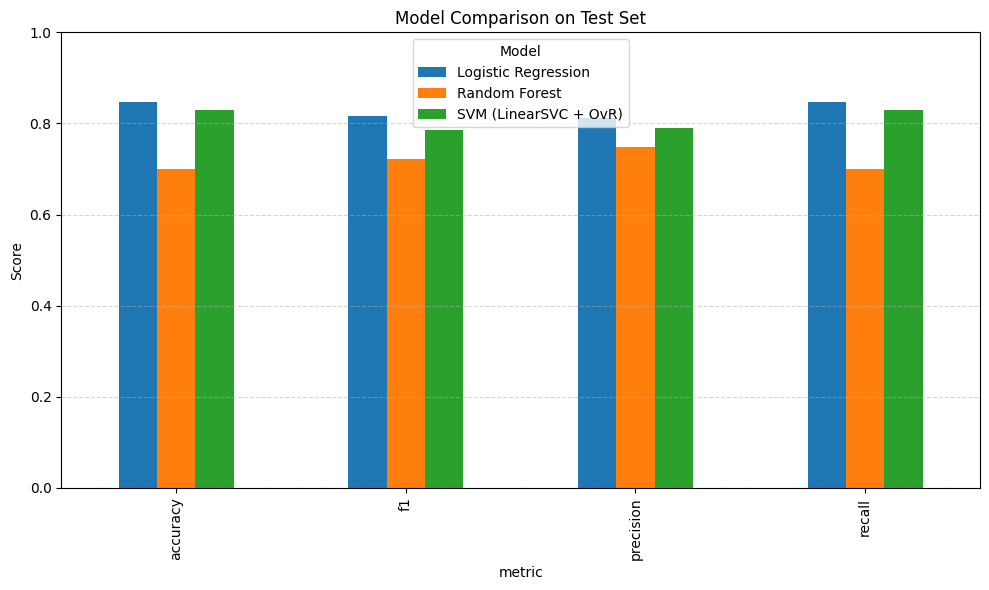

In [8]:
# Grouped bar chart: metrics on x-axis, models as bars

pivot_df = metrics_long.pivot(index="metric", columns="model", values="value")

ax = pivot_df.plot(kind="bar", figsize=(10, 6))

ax.set_title("Model Comparison on Test Set")
ax.set_ylabel("Score")
ax.set_ylim(0, 1.0)
ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.legend(title="Model")
plt.tight_layout()
plt.show()

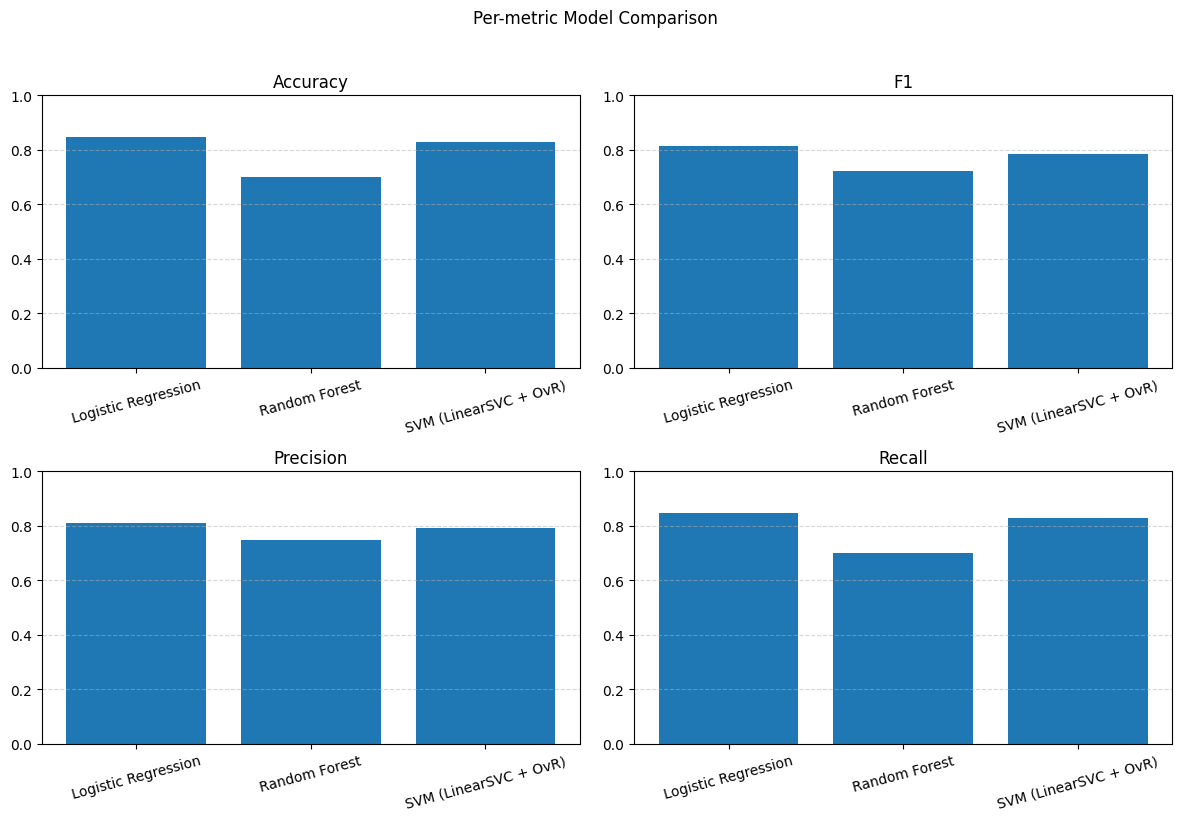

In [9]:
# One plot per metric
metrics = ["accuracy", "f1", "precision", "recall"]

plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    subset = metrics_long[metrics_long["metric"] == metric]
    plt.bar(subset["model"], subset["value"])
    plt.title(metric.capitalize())
    plt.ylim(0, 1.0)
    plt.xticks(rotation=15)
    plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.suptitle("Per-metric Model Comparison", y=1.02)
plt.tight_layout()
plt.show()

## 8. Per-Class Accuracy for Each Model

In [10]:
from pyspark.sql.functions import sum as spark_sum, when

def per_class_accuracy(model, test_df, model_name="model"):
    preds = model.transform(test_df)
    per_class = preds.groupBy("label").agg(
        count("*").alias("total"),
        spark_sum(when(col("label") == col("prediction"), 1).otherwise(0)).alias("correct"),
    )
    per_class = per_class.withColumn("accuracy", col("correct") / col("total"))
    pdf = per_class.orderBy("label").toPandas()
    pdf["model"] = model_name
    return pdf

per_class_lr  = per_class_accuracy(lr_model,  test_df, "Logistic Regression")
per_class_rf  = per_class_accuracy(rf_model,  test_df, "Random Forest")
per_class_svm = per_class_accuracy(svm_model, test_df, "SVM (LinearSVC + OvR)")

per_class_all = pd.concat([per_class_lr, per_class_rf, per_class_svm], ignore_index=True)
per_class_all

,label,total,correct,accuracy,model
0,0.0,1075878,589687,0.548098,Logistic Regression
1,1.0,490894,25901,0.052763,Logistic Regression
2,2.0,5477034,5344395,0.975783,Logistic Regression
3,0.0,1075878,499984,0.464722,Random Forest
4,1.0,490894,137069,0.279223,Random Forest
5,2.0,5477034,4287376,0.782792,Random Forest
6,0.0,1075878,435482,0.404769,SVM (LinearSVC + OvR)
7,1.0,490894,840,0.001711,SVM (LinearSVC + OvR)
8,2.0,5477034,5409314,0.987636,SVM (LinearSVC + OvR)


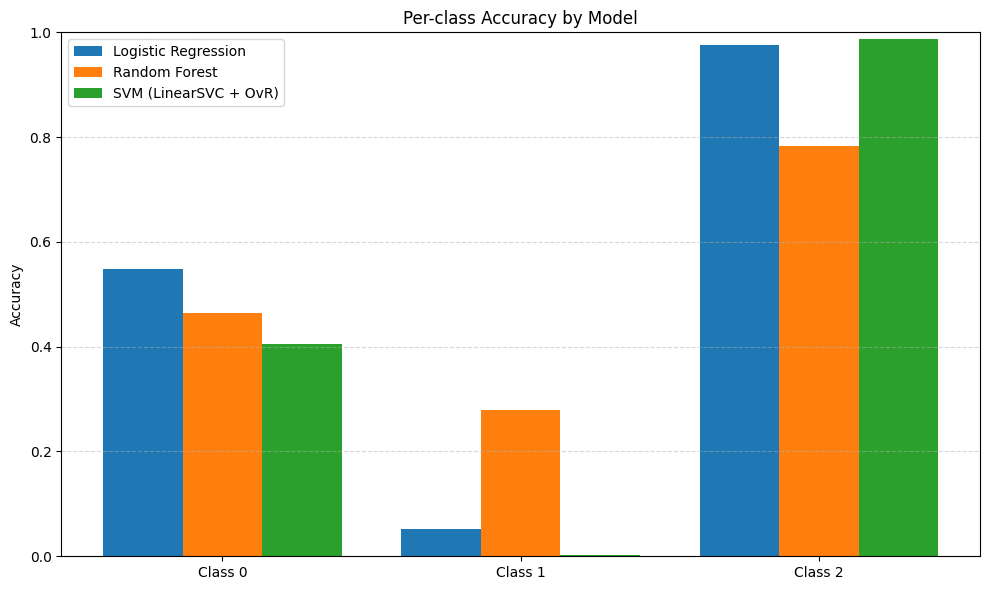

In [11]:
# Plot per-class accuracy comparison
plt.figure(figsize=(10, 6))

labels = sorted(per_class_all["label"].unique())
models = per_class_all["model"].unique()
width = 0.8 / len(models)

for i, model_name in enumerate(models):
    subset = per_class_all[per_class_all["model"] == model_name]
    positions = [l + (i - len(models)/2) * width + width/2 for l in subset["label"]]
    plt.bar(positions, subset["accuracy"], width=width, label=model_name)

plt.xticks(labels, [f"Class {int(l)}" for l in labels])
plt.ylabel("Accuracy")
plt.title("Per-class Accuracy by Model")
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## 9. Shutdown Spark

In [12]:
spark.stop()
print("✓ Spark session stopped.")

✓ Spark session stopped.
